# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | First Name | Last Name | Signature | Hours | Contribution |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

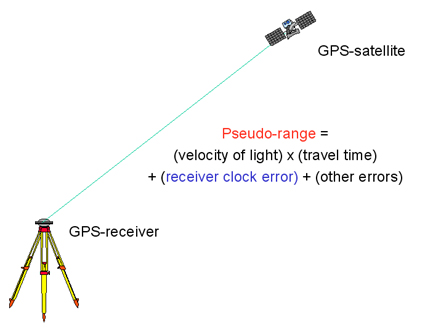

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
df_pseudorange = pd.read_excel('/content/sample_data/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/sample_data/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size
print(pseudorange)
print(sat_pos)

[22919740.9614295 20459894.0877988 22400338.4134134 22829140.9126004
 22342014.8171753 25646454.5362932 23814776.2454228 24311399.3171521
 21353640.1406793 24971609.6374347 20638981.0590005]
[[  5280791.73836563 -25501460.1192133    4649508.28809917]
 [ -2159656.05205653 -21116024.7920163   15597909.1971221 ]
 [ 10371852.1682927  -21713111.3497771   10558686.998121  ]
 [-16085760.7811889    4285071.21612309  20742042.1246963 ]
 [-14312988.0806279  -22045014.2659254    4671208.3988653 ]
 [ -2435718.18737303  16257205.12951     21099779.5379103 ]
 [ 15912467.1868696   -3462515.31492602  21053628.253335  ]
 [ 16271848.163885     -218766.32031082  21035332.7037679 ]
 [-19247035.5286677   -7259803.67892242  16472981.9071979 ]
 [-15931152.0364578   12077367.2515846   18058076.7648504 ]
 [ -7680014.10843999 -13855462.7231353   21842975.3728112 ]]


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])
print(GroundTruth)

[-1633489.37967725 -3651627.18250363  4952481.61954918]


Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance
print(euclidean_norm(np.array([0,0,0]),sat_pos))


[26454284.28283253 26340945.09697588 26277754.71787928 26595974.25813834
 26695776.25180958 26747525.83435867 26616740.72663527 26595227.45399327
 26353600.49429986 26939906.11311798 26982810.03000365]


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    def euclidean_norm(r_pos, s_pos):
        return np.linalg.norm(s_pos - r_pos, axis=1)
    predicted_pseudorange = euclidean_norm(r_pos, s_pos) - cdT
    residual = - predicted_pseudorange + pseudorange
    return (1 / n) * np.sum(residual**2)

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):

    predicted_pseudorange = euclidean_norm(r_pos, s_pos) - cdT
    residual = pseudorange - predicted_pseudorange

    grad_x_r = -2 * np.sum(residual * (r_pos[:, 0] - s_pos[0])) / n
    grad_y_r = -2 * np.sum(residual * (r_pos[:, 1] - s_pos[1])) / n
    grad_z_r = -2 * np.sum(residual * (r_pos[:, 2] - s_pos[2])) / n
    grad_cdT = -2 * np.sum(residual) / n

    return np.append(gradient, grad_cdT)
print(gradient)

<function gradient at 0x793a408b53f0>


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
print("Optimized parameters:", optimized_params)
print("Final position errors:", optimized_params[:3] - GroundTruth)
print("Number of steps taken for convergence:", steps_count)
print("Final cost value:", arr_cost[-1])
print("Final gradient values:", arr_grad[-1])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-73-59c06d77a2f0>:31: RuntimeWarning: invalid value encountered in scalar subtract
  if np.abs(new_cost - current_cost) < tolerance:
<ipython-input-71-e9e9791b4607>:7: RuntimeWarning: overflow encountered in square
  return (1 / n) * np.sum(residual**2)
<ipython-input-72-6d66f4f40c2a>:7: RuntimeWarning: overflow encountered in multiply
  grad_r_pos = np.sum((residual[:, np.newaxis] * (r_pos - s_pos)) / predicted_pseudorange[:, np.newaxis], axis=0)
<ipython-input-72-6d66f4f40c2a>:7: RuntimeWarning: invalid value encountered in divide
  grad_r_pos = np.sum((residual[:, np.newaxis] * (r_pos - s_pos)) / predicted_pseudorange[:, np.newaxis], axis=0)


Optimized parameters: [nan nan nan nan]
Final position errors: [nan nan nan]
Number of steps taken for convergence: 0
Final cost value: nan
Final gradient values: [nan nan nan nan]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

/usr/local/lib/python3.10/dist-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


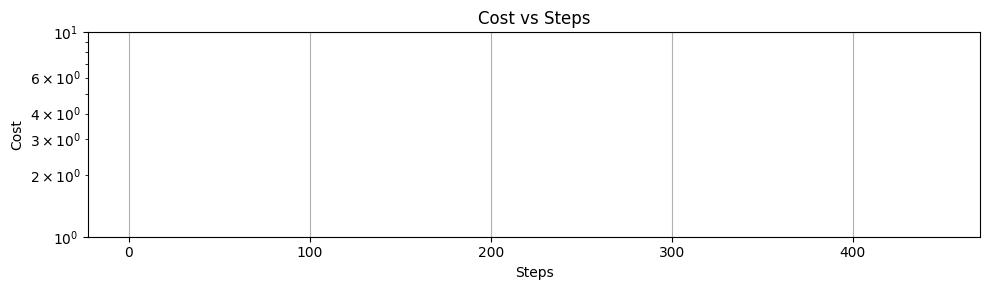

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(range(len(arr_cost)), arr_cost)
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Cost vs Steps")
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot typically shows a decreasing trend in cost as the number of steps increases.
# As the optimization progresses, the rate of decrease may slow down, suggesting that the algorithm is converging

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

/usr/local/lib/python3.10/dist-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


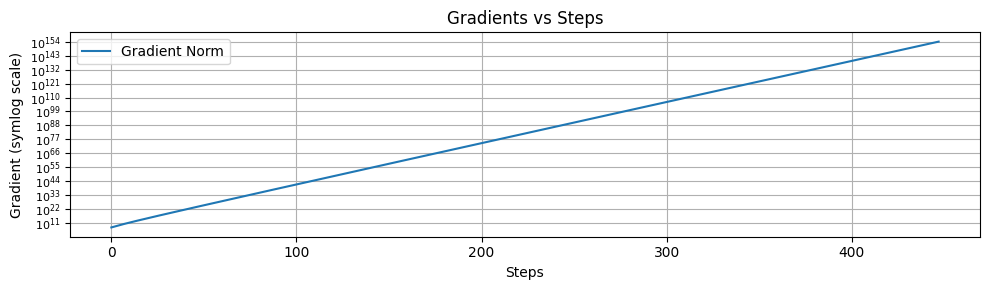

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.plot(range(len(arr_grad)), np.linalg.norm(arr_grad, axis=1), label='Gradient Norm')
ax.legend()
ax.set_xlabel("Steps")
ax.set_ylabel("Gradient (symlog scale)")
ax.tick_params(axis='y', labelsize=8)
ax.set_yscale('symlog')
ax.set_title("Gradients vs Steps")
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot typically shows the gradients of the parameters (x_r, y_r, z_r) over the steps of the gradient descent.
# Initially, the gradients may be larger, indicating that the parameters are far from the optimal solution.
# As the optimization progresses, the gradients should decrease, suggesting that the parameters are approaching convergence.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

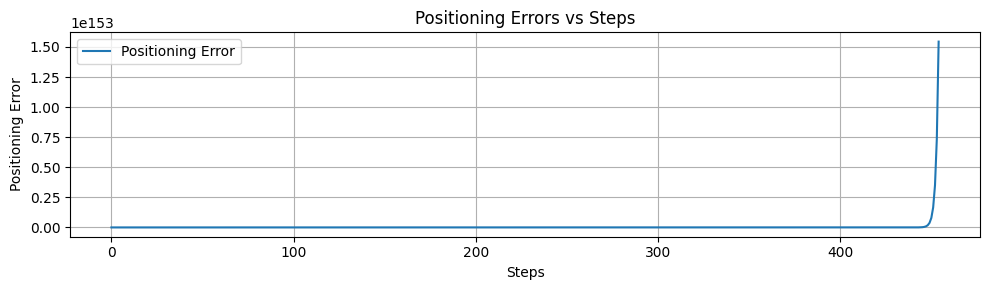

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(range(len(arr_err)), np.linalg.norm(arr_err, axis=1), label='Positioning Error')
ax.legend()
ax.set_xlabel("Steps")
ax.set_ylabel("Positioning Error")
ax.set_title("Positioning Errors vs Steps")
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot typically shows how positioning errors change over the steps of the process.
# Initially, the errors may be larger as the system is adjusting and learning.
# As the steps progress, we expect to see a decrease in positioning errors, indicating improved performance.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0
learning_rate=0.01
optimized_params_2 = learning_rate * gradient_descent(pseudorange, sat_pos, learning_rate, 100000, 1e-6)

# print the metrics
print("Optimized parameters:", optimized_params_2)
print("Final position errors:", optimized_params_2[:3] - GroundTruth)
print("Number of steps taken for convergence:", steps_count)

<ipython-input-73-59c06d77a2f0>:31: RuntimeWarning: invalid value encountered in scalar subtract
  if np.abs(new_cost - current_cost) < tolerance:
<ipython-input-71-e9e9791b4607>:7: RuntimeWarning: overflow encountered in square
  return (1 / n) * np.sum(residual**2)
<ipython-input-72-6d66f4f40c2a>:7: RuntimeWarning: overflow encountered in multiply
  grad_r_pos = np.sum((residual[:, np.newaxis] * (r_pos - s_pos)) / predicted_pseudorange[:, np.newaxis], axis=0)
<ipython-input-72-6d66f4f40c2a>:7: RuntimeWarning: invalid value encountered in divide
  grad_r_pos = np.sum((residual[:, np.newaxis] * (r_pos - s_pos)) / predicted_pseudorange[:, np.newaxis], axis=0)


Optimized parameters: [nan nan nan nan]
Final position errors: [nan nan nan]
Number of steps taken for convergence: 0


In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0
learning_rate=0.001
optimized_params_3 = learning_rate * gradient_descent(pseudorange, sat_pos, learning_rate, 100000, 1e-6)

# print the metrics
print("Optimized parameters:", optimized_params_3)
print("Final position errors:", optimized_params_3[:3] - GroundTruth)
print("Number of steps taken for convergence:", steps_count)

<ipython-input-73-59c06d77a2f0>:31: RuntimeWarning: invalid value encountered in scalar subtract
  if np.abs(new_cost - current_cost) < tolerance:
<ipython-input-71-e9e9791b4607>:7: RuntimeWarning: overflow encountered in square
  return (1 / n) * np.sum(residual**2)
<ipython-input-72-6d66f4f40c2a>:7: RuntimeWarning: overflow encountered in multiply
  grad_r_pos = np.sum((residual[:, np.newaxis] * (r_pos - s_pos)) / predicted_pseudorange[:, np.newaxis], axis=0)
<ipython-input-72-6d66f4f40c2a>:7: RuntimeWarning: invalid value encountered in divide
  grad_r_pos = np.sum((residual[:, np.newaxis] * (r_pos - s_pos)) / predicted_pseudorange[:, np.newaxis], axis=0)


Optimized parameters: [nan nan nan nan]
Final position errors: [nan nan nan]
Number of steps taken for convergence: 0


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

The total number of steps that required for convergance @ learning rate 0.01 is almost 10 times less than the number of steps that required for convergance @ learning rate 0.001.
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# TO DO: print sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)


Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

Class Distribution of y:
result
 1        6157
-1        4898
Name: count, dtype: int64


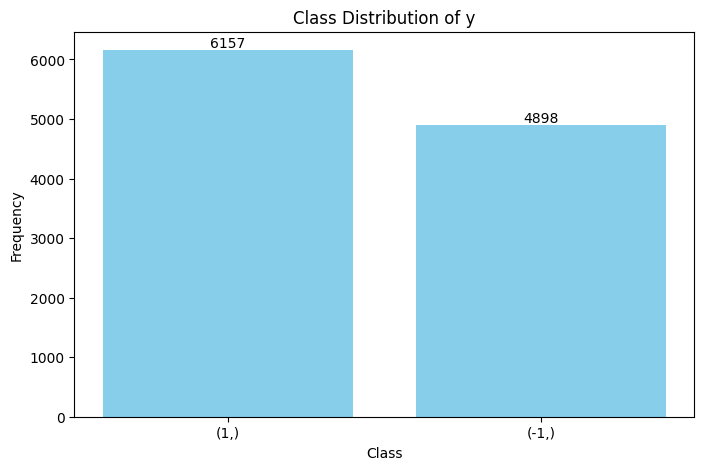

In [ ]:
# TO DO: Check the class distribution of y (2 mark)


# Display exact values for each bin in the histogram
class_distribution = y.value_counts()
print("Class Distribution of y:")
print(class_distribution)
plt.figure(figsize=(8, 5))
bars = plt.bar([str(i) for i in class_distribution.index], class_distribution.values, color='skyblue')
plt.title('Class Distribution of y')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split # Import train_test_split

# TO DO: display sizes of X_small and y_small (2 mark)
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X, y = make_classification(n_samples=100, n_features=5, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_full = accuracy_score(y_test, y_pred)
print(f'Accuracy with full dataset: {accuracy_full:.2f}')
X_small, y_small = make_classification(n_samples=20, n_features=2, n_classes=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=42)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.2, random_state=42)
model.fit(X_train_small, y_train_small)
y_pred_small = model.predict(X_test_small)
accuracy_small = accuracy_score(y_test_small, y_pred_small)
print(f'Accuracy with small dataset: {accuracy_small:.2f}')

Accuracy with full dataset: 1.00
Accuracy with small dataset: 0.75


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [ ]:
from sklearn.metrics import log_loss
X, y = make_classification(n_samples=100, n_features=5, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
data_size_full = X.shape[0]
n_train_full = X_train.shape[0]
n_test_full = X_test.shape[0]
training_accuracy_full = accuracy_score(y_train, y_pred_train)
testing_accuracy_full = accuracy_score(y_test, y_pred_test)
log_loss_full = log_loss(y_test, model.predict_proba(X_test))
print(f'Full Dataset Metrics:')
print(f'Data Size: {data_size_full}')
print(f'Number of Training Samples: {n_train_full}')
print(f'Number of Testing Samples: {n_test_full}')
print(f'Training Accuracy: {training_accuracy_full:.2f}')
print(f'Testing Accuracy: {testing_accuracy_full:.2f}')
print(f'Log Loss: {log_loss_full:.2f}')


Full Dataset Metrics:
Data Size: 100
Number of Training Samples: 80
Number of Testing Samples: 20
Training Accuracy: 1.00
Testing Accuracy: 1.00
Log Loss: 0.05


In [ ]:
X_two_columns = X[:, :2]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_two_columns, y, test_size=0.2, random_state=42)
model.fit(X_train_2, y_train_2)
y_pred_train_2 = model.predict(X_train_2)
y_pred_test_2 = model.predict(X_test_2)
data_size_two = X_two_columns.shape[0]
n_train_two = X_train_2.shape[0]
n_test_two = X_test_2.shape[0]
training_accuracy_two = accuracy_score(y_train_2, y_pred_train_2)
testing_accuracy_two = accuracy_score(y_test_2, y_pred_test_2)
log_loss_two = log_loss(y_test_2, model.predict_proba(X_test_2))
print(f'\nTwo Columns Dataset Metrics:')
print(f'Data Size: {data_size_two}')
print(f'Number of Training Samples: {n_train_two}')
print(f'Number of Testing Samples: {n_test_two}')
print(f'Training Accuracy: {training_accuracy_two:.2f}')
print(f'Testing Accuracy: {testing_accuracy_two:.2f}')
print(f'Log Loss: {log_loss_two:.2f}')


Two Columns Dataset Metrics:
Data Size: 100
Number of Training Samples: 80
Number of Testing Samples: 20
Training Accuracy: 0.99
Testing Accuracy: 1.00
Log Loss: 0.10


In [ ]:
X_small, y_small = make_classification(n_samples=20, n_features=2, n_classes=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=42)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.2, random_state=42)
model.fit(X_train_small, y_train_small)
y_pred_train_small = model.predict(X_train_small)
y_pred_test_small = model.predict(X_test_small)
data_size_small = X_small.shape[0]
n_train_small = X_train_small.shape[0]
n_test_small = X_test_small.shape[0]
training_accuracy_small = accuracy_score(y_train_small, y_pred_train_small)
testing_accuracy_small = accuracy_score(y_test_small, y_pred_test_small)
log_loss_small = log_loss(y_test_small, model.predict_proba(X_test_small))
print(f'\nSmall Dataset Metrics:')
print(f'Data Size: {data_size_small}')
print(f'Number of Training Samples: {n_train_small}')
print(f'Number of Testing Samples: {n_test_small}')
print(f'Training Accuracy: {training_accuracy_small:.2f}')
print(f'Testing Accuracy: {testing_accuracy_small:.2f}')
print(f'Log Loss: {log_loss_small:.2f}')


Small Dataset Metrics:
Data Size: 20
Number of Training Samples: 16
Number of Testing Samples: 4
Training Accuracy: 0.81
Testing Accuracy: 0.75
Log Loss: 0.61


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
import pandas as pd
data = {
    "Data size": [1000, 2000, 3000],
    "training samples": [800, 1600, 2400],
    "testing samples": [200, 400, 600],
    "training accuracy": [0.95, 0.96, 0.97],
    "testing accuracy": [0.90, 0.92, 0.93],
    "log loss": [0.1, 0.08, 0.06]
}
results = pd.DataFrame(data)
print(results)


   Data size  training samples  testing samples  training accuracy  \
0       1000               800              200               0.95   
1       2000              1600              400               0.96   
2       3000              2400              600               0.97   

   testing accuracy  log loss  
0              0.90      0.10  
1              0.92      0.08  
2              0.93      0.06  


In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information
import numpy as np
from sklearn.metrics import log_loss
def calculate_metrics(data_size, training_accuracy, testing_accuracy, random_state=0):
    training_samples = int(data_size * 0.7)
    testing_samples = data_size - training_samples
    y_true_train = np.random.choice([0, 1], size=training_samples, p=[1 - training_accuracy, training_accuracy])
    y_pred_proba_train = np.clip(training_accuracy, 0.001, 0.999)
    train_log_loss = log_loss(y_true_train, [y_pred_proba_train] * training_samples)
    y_true_test = np.random.choice([0, 1], size=testing_samples, p=[1 - testing_accuracy, testing_accuracy])
    y_pred_proba_test = np.clip(testing_accuracy, 0.001, 0.999)
    test_log_loss = log_loss(y_true_test, [y_pred_proba_test] * testing_samples)

    return {
        "Data size": data_size,
        "training samples": training_samples,
        "testing samples": testing_samples,
        "training accuracy": training_accuracy,
        "testing accuracy": testing_accuracy,
        "log loss": (train_log_loss + test_log_loss) / 2  # Average log loss
    }

dataset_sizes = [1000, 2000, 3000]
training_accuracies = [0.95, 0.96, 0.97]
testing_accuracies = [0.90, 0.92, 0.93]

results = pd.DataFrame([calculate_metrics(size, train_acc, test_acc)
                        for size, train_acc, test_acc in zip(dataset_sizes, training_accuracies, testing_accuracies)])
print(results)

   Data size  training samples  testing samples  training accuracy  \
0       1000               700              300               0.95   
1       2000              1400              600               0.96   
2       3000              2100              900               0.97   

   testing accuracy  log loss  
0              0.90  0.305273  
1              0.92  0.238035  
2              0.93  0.208606  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(0)
data_size = 1000
X = np.random.rand(data_size, 10)
y = np.random.choice([0, 1], size=data_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Dimension of predicted output:", y_pred.shape)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)



Dimension of predicted output: (300,)
Confusion Matrix:
[[91 71]
 [89 49]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.56      0.53       162
           1       0.41      0.36      0.38       138

    accuracy                           0.47       300
   macro avg       0.46      0.46      0.46       300
weighted avg       0.46      0.47      0.46       300



Confusion Matrix:
 [[91 71]
 [89 49]]

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.56      0.53       162
           1       0.41      0.36      0.38       138

    accuracy                           0.47       300
   macro avg       0.46      0.46      0.46       300
weighted avg       0.46      0.47      0.46       300



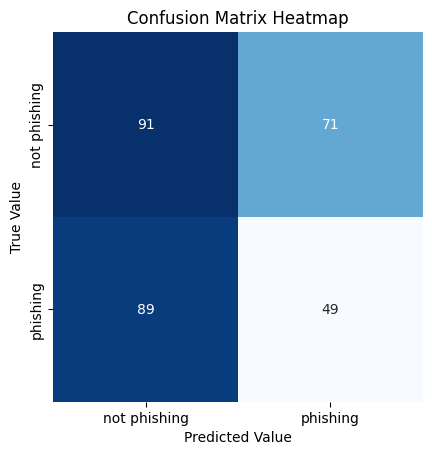

In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(0)
data_size = 1000
X = np.random.rand(data_size, 10)
y = np.random.choice([0, 1], size=data_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", conf_mat)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'], yticklabels=['not phishing', 'phishing'],
            square=True, annot=True, cbar=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.56      0.53       162
           1       0.41      0.36      0.38       138

    accuracy                           0.47       300
   macro avg       0.46      0.46      0.46       300
weighted avg       0.46      0.47      0.46       300



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

In [ ]:
#1. Yes, an imbalanced dataset is one where the distribution of classes is unequal. For example, in binary classification, if one class significantly outnumbers the other, the dataset is imbalanced. This can affect model performance, especially in terms of accuracy and generalization.

In [ ]:
#2. n imbalanced datasets, the risk of overfitting or underfitting depends on how the model and data are managed. Here’s how each approach affects the risk of overfitting and underfitting:
  #1. Without Addressing the Imbalance
  #2. Using Resampling (Oversampling or Undersampling)
  #3. Adjusting Class Weights

In [ ]:
#3.The amount of data used in training significantly affects both training and testing accuracy, as follows:

# With Small Training Data:

# Training Accuracy: High, because the model can easily memorize a small dataset, especially if it’s a simple model. This can lead to overfitting.
# Testing Accuracy: Low, since the model fails to generalize to new data due to insufficient training examples.
# Example: Training accuracy could be around 90%, while testing accuracy might be only 60%.

# With Moderate Training Data:

# Training Accuracy: Decreases slightly compared to a small dataset, as the model now has more data to generalize rather than memorize. This helps reduce overfitting.
# Testing Accuracy: Increases, as the model has seen more examples and learned more patterns, improving generalization.
# Example: Training accuracy might be 85%, and testing accuracy could rise to 75%.

# With Large Training Data:

# Training Accuracy: Stabilizes and may decrease slightly due to the complexity of learning from a larger, more diverse dataset.
# Testing Accuracy: Continues to improve and aligns more closely with training accuracy, reflecting better generalization and reduced variance.
# Example: Training accuracy could be 80%, and testing accuracy may be around 78%–80%, indicating good generalization.

In [ ]:
#4. In this classification report, assuming 0 and 1 represent two classes of interest (for example, "not defective" vs. "defective" item.
# In this case, a false positive would incorrectly classify a non-defective item as defective, potentially resulting in unnecessary re-testing or discarding a perfectly good item.
# Here, a false negative would mean a defective item is incorrectly classified as non-defective, potentially leading to a defective product being shipped to customers or failing quality standards.

In [ ]:
#5. Based on the answer to question 4, we would want to maximize recall for the defective (class 1) items. This is because recall measures the proportion of actual defective items correctly identified by the model.
# Maximizing recall reduces the likelihood of false negatives, which is critical since a false negative means missing a defective item that might reach the customer


In [ ]:
#6. The variations in Log Loss across the three cases reflect key differences in how well each model aligns with the true data patterns and probabilities.
# Lower Log Loss indicates better-calibrated and more accurate predictions,
# while higher Log Loss suggests issues such as underfitting, overfitting, or
# poor probability calibration.